In [2]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from transformers import AdamW, get_scheduler

from jre_utils.datapath import (
    processed_pretraining_data_paths,
    pretraining_data_paths,
    pretrained_weights_paths,
)
from jre_utils.data import TimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.engine import (
    evaluate,
    train,
    EarlyStopper,
)
from jre_utils.metrics import MSELossWeighted

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [42]:
dataset = "swat"
df = pd.read_csv(pretraining_data_paths[dataset])

In [43]:
df

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,2.427057,522.8467,2.0,2.0,1.0,262.0161,8.396437,328.6337,2.445391,2.0,1.0,1.0,2.0,1.0,2.0,1.0,19.74838,2.206835,956.1651,1.0,2.0,1.0,1.0,1.0,2.0,148.8080,156.0882,1.713517,942.0662,1.0,2.0,1.0,1.0,2.0,7.878621,145.1166,264.5475,12.03538,1.723789,1.279621,0.735269,0.307786,2.0,1.0,250.8652,1.649953,189.5988,0.000128,1.0,1.0,1.0,0
1,2.446274,522.8860,2.0,2.0,1.0,262.0161,8.396437,328.6337,2.445391,2.0,1.0,1.0,2.0,1.0,2.0,1.0,19.74838,2.208244,956.1651,1.0,2.0,1.0,1.0,1.0,2.0,148.8080,156.0882,1.715952,942.0277,1.0,2.0,1.0,1.0,2.0,7.878621,145.1166,264.5475,12.03538,1.723789,1.297554,0.735269,0.307786,2.0,1.0,250.8652,1.649953,189.6789,0.000128,1.0,1.0,1.0,0
2,2.489191,522.8467,2.0,2.0,1.0,262.0161,8.394514,328.6337,2.442316,2.0,1.0,1.0,2.0,1.0,2.0,1.0,19.69076,2.208628,956.4855,1.0,2.0,1.0,1.0,1.0,2.0,148.8080,156.0882,1.715952,941.8739,1.0,2.0,1.0,1.0,2.0,7.878621,145.1166,264.5475,12.03538,1.723404,1.293967,0.735269,0.308619,2.0,1.0,250.8812,1.649953,189.6789,0.000128,1.0,1.0,1.0,0
3,2.534350,522.9645,2.0,2.0,1.0,262.0161,8.394514,328.6337,2.442316,2.0,1.0,1.0,2.0,1.0,2.0,1.0,19.69076,2.208628,956.8060,1.0,2.0,1.0,1.0,1.0,2.0,148.8080,156.0882,1.714670,941.7970,1.0,2.0,1.0,1.0,2.0,7.878621,145.0141,264.5475,12.03538,1.723404,1.281158,0.735269,0.308619,2.0,1.0,250.8812,1.649953,189.6148,0.000128,1.0,1.0,1.0,0
4,2.569260,523.4748,2.0,2.0,1.0,262.0161,8.394514,328.6337,2.443085,2.0,1.0,1.0,2.0,1.0,2.0,1.0,19.69076,2.208628,957.0864,1.0,2.0,1.0,1.0,1.0,2.0,148.8080,156.0882,1.714670,942.2200,1.0,2.0,1.0,1.0,2.0,7.878621,144.8859,264.5475,12.03538,1.723404,1.281158,0.735269,0.308619,2.0,1.0,250.8812,1.649953,189.5027,0.000128,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2.559972,519.5495,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.459488,2.0,2.0,1.0,2.0,1.0,2.0,1.0,20.39823,2.196586,974.5498,1.0,2.0,1.0,1.0,1.0,2.0,148.8032,145.6037,1.705315,956.8701,1.0,2.0,1.0,1.0,2.0,7.745642,139.1182,257.1136,14.80390,1.716483,1.288971,0.734885,0.306569,2.0,1.0,251.1535,0.865024,189.0220,0.000000,1.0,1.0,1.0,0
449915,2.549082,520.4131,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.459488,2.0,2.0,1.0,2.0,1.0,2.0,1.0,20.39823,2.196586,974.5898,1.0,2.0,1.0,1.0,1.0,2.0,148.8032,145.6037,1.705315,957.1777,1.0,2.0,1.0,1.0,2.0,7.745642,139.1182,257.1136,14.80390,1.714560,1.272704,0.734885,0.306569,2.0,1.0,251.0734,0.865024,188.9259,0.000000,1.0,1.0,1.0,0
449916,2.531467,520.6878,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.460129,2.0,2.0,1.0,2.0,1.0,2.0,1.0,20.33101,2.195561,974.2695,1.0,2.0,1.0,1.0,1.0,2.0,148.8032,145.5524,1.706212,957.2930,1.0,2.0,1.0,1.0,2.0,7.745642,139.1182,257.1136,14.80390,1.714560,1.269502,0.734885,0.306569,2.0,1.0,251.0734,0.865024,188.9259,0.000000,1.0,1.0,1.0,0
449917,2.521218,520.7271,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.460129,2.0,2.0,1.0,2.0,1.0,2.0,1.0,20.29579,2.195561,974.2294,1.0,2.0,1.0,1.0,1.0,2.0,148.8032,145.5524,1.706212,957.6775,1.0,2.0,1.0,1.0,2.0,7.745642,139.1182,257.1136,14.80390,1.714560,1.263866,0.734885,0.307978,2.0,1.0,251.0734,0.865024,188.9259,0.000000,1.0,1.0,1.0,0


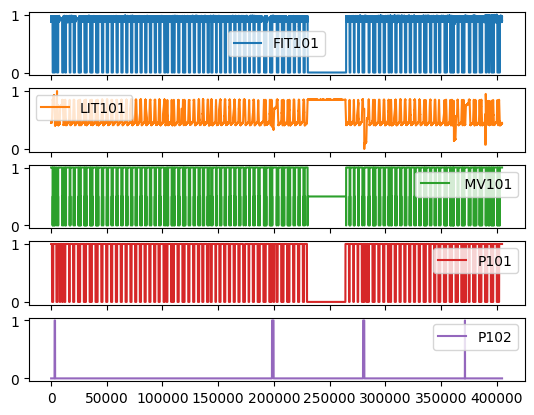

In [44]:
plot_cols = ['FIT101', 'LIT101', ' MV101', 'P101', 'P102',]
plot_features = train_df[plot_cols]
_ = plot_features.plot(subplots=True)


In [45]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
FIT101,449919.0,1.714346,1.191716,0.000000,0.000000,2.477020,2.577907,2.760145
LIT101,449919.0,607.019967,125.303003,189.826300,510.011100,530.422500,727.432100,925.032300
MV101,449919.0,1.665335,0.482323,0.000000,1.000000,2.000000,2.000000,2.000000
P101,449919.0,1.693251,0.461145,1.000000,1.000000,2.000000,2.000000,2.000000
P102,449919.0,1.006946,0.083051,1.000000,1.000000,1.000000,1.000000,2.000000
AIT201,449919.0,210.297302,35.157909,168.033800,177.102000,193.508100,253.845200,267.719800
AIT202,449919.0,8.528535,0.114844,6.000000,8.441618,8.551525,8.610806,8.733210
AIT203,449919.0,320.301478,16.631029,285.337100,306.383000,321.661100,331.684200,384.465500
FIT201,449919.0,1.702908,1.130277,0.000000,0.000000,2.446673,2.454362,2.826899
MV201,449919.0,1.691584,0.470611,0.000000,1.000000,2.000000,2.000000,2.000000


In [56]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.9)]
val_df = df[int(n*0.9):]

num_features = df.shape[1]

In [57]:
df

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P202,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P301,P302,AIT401,AIT402,FIT401,LIT401,P401,P402,P403,P404,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,2.427057,522.8467,2.0,2.0,1.0,262.0161,8.396437,328.6337,2.445391,2.0,1.0,1.0,2.0,1.0,2.0,1.0,19.74838,2.206835,956.1651,1.0,2.0,1.0,1.0,1.0,2.0,148.8080,156.0882,1.713517,942.0662,1.0,2.0,1.0,1.0,2.0,7.878621,145.1166,264.5475,12.03538,1.723789,1.279621,0.735269,0.307786,2.0,1.0,250.8652,1.649953,189.5988,0.000128,1.0,1.0,1.0,0
1,2.446274,522.8860,2.0,2.0,1.0,262.0161,8.396437,328.6337,2.445391,2.0,1.0,1.0,2.0,1.0,2.0,1.0,19.74838,2.208244,956.1651,1.0,2.0,1.0,1.0,1.0,2.0,148.8080,156.0882,1.715952,942.0277,1.0,2.0,1.0,1.0,2.0,7.878621,145.1166,264.5475,12.03538,1.723789,1.297554,0.735269,0.307786,2.0,1.0,250.8652,1.649953,189.6789,0.000128,1.0,1.0,1.0,0
2,2.489191,522.8467,2.0,2.0,1.0,262.0161,8.394514,328.6337,2.442316,2.0,1.0,1.0,2.0,1.0,2.0,1.0,19.69076,2.208628,956.4855,1.0,2.0,1.0,1.0,1.0,2.0,148.8080,156.0882,1.715952,941.8739,1.0,2.0,1.0,1.0,2.0,7.878621,145.1166,264.5475,12.03538,1.723404,1.293967,0.735269,0.308619,2.0,1.0,250.8812,1.649953,189.6789,0.000128,1.0,1.0,1.0,0
3,2.534350,522.9645,2.0,2.0,1.0,262.0161,8.394514,328.6337,2.442316,2.0,1.0,1.0,2.0,1.0,2.0,1.0,19.69076,2.208628,956.8060,1.0,2.0,1.0,1.0,1.0,2.0,148.8080,156.0882,1.714670,941.7970,1.0,2.0,1.0,1.0,2.0,7.878621,145.0141,264.5475,12.03538,1.723404,1.281158,0.735269,0.308619,2.0,1.0,250.8812,1.649953,189.6148,0.000128,1.0,1.0,1.0,0
4,2.569260,523.4748,2.0,2.0,1.0,262.0161,8.394514,328.6337,2.443085,2.0,1.0,1.0,2.0,1.0,2.0,1.0,19.69076,2.208628,957.0864,1.0,2.0,1.0,1.0,1.0,2.0,148.8080,156.0882,1.714670,942.2200,1.0,2.0,1.0,1.0,2.0,7.878621,144.8859,264.5475,12.03538,1.723404,1.281158,0.735269,0.308619,2.0,1.0,250.8812,1.649953,189.5027,0.000128,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449914,2.559972,519.5495,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.459488,2.0,2.0,1.0,2.0,1.0,2.0,1.0,20.39823,2.196586,974.5498,1.0,2.0,1.0,1.0,1.0,2.0,148.8032,145.6037,1.705315,956.8701,1.0,2.0,1.0,1.0,2.0,7.745642,139.1182,257.1136,14.80390,1.716483,1.288971,0.734885,0.306569,2.0,1.0,251.1535,0.865024,189.0220,0.000000,1.0,1.0,1.0,0
449915,2.549082,520.4131,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.459488,2.0,2.0,1.0,2.0,1.0,2.0,1.0,20.39823,2.196586,974.5898,1.0,2.0,1.0,1.0,1.0,2.0,148.8032,145.6037,1.705315,957.1777,1.0,2.0,1.0,1.0,2.0,7.745642,139.1182,257.1136,14.80390,1.714560,1.272704,0.734885,0.306569,2.0,1.0,251.0734,0.865024,188.9259,0.000000,1.0,1.0,1.0,0
449916,2.531467,520.6878,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.460129,2.0,2.0,1.0,2.0,1.0,2.0,1.0,20.33101,2.195561,974.2695,1.0,2.0,1.0,1.0,1.0,2.0,148.8032,145.5524,1.706212,957.2930,1.0,2.0,1.0,1.0,2.0,7.745642,139.1182,257.1136,14.80390,1.714560,1.269502,0.734885,0.306569,2.0,1.0,251.0734,0.865024,188.9259,0.000000,1.0,1.0,1.0,0
449917,2.521218,520.7271,2.0,2.0,1.0,168.0979,8.638683,301.9226,2.460129,2.0,2.0,1.0,2.0,1.0,2.0,1.0,20.29579,2.195561,974.2294,1.0,2.0,1.0,1.0,1.0,2.0,148.8032,145.5524,1.706212,957.6775,1.0,2.0,1.0,1.0,2.0,7.745642,139.1182,257.1136,14.80390,1.714560,1.263866,0.734885,0.307978,2.0,1.0,251.0734,0.865024,188.9259,0.000000,1.0,1.0,1.0,0


In [58]:
train_min = train_df.min()
train_max = train_df.max()

train_df = (train_df - train_min) / (train_max - train_min)
train_df = train_df.dropna(axis=1)
val_df = (val_df - train_min) / (train_max - train_min)
val_df = val_df.dropna(axis=1)


In [59]:
train_df

,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,MV201,P201,P203,P204,P205,P206,DPIT301,FIT301,LIT301,MV301,MV302,MV303,MV304,P302,AIT401,AIT402,FIT401,LIT401,P402,P403,UV401,AIT501,AIT502,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,P501,PIT501,PIT502,PIT503,FIT601,P602,Normal/Attack
0,0.882600,0.452962,1.0,1.0,0.0,0.939865,0.879983,0.436773,0.865044,1.0,0.0,1.0,0.0,1.0,0.0,0.438853,0.928726,0.605510,0.5,1.0,0.5,0.5,1.0,0.5,0.076831,0.982007,0.920088,1.0,0.0,1.0,0.562703,0.101190,0.366624,0.005773,0.982970,0.940678,0.991540,0.987464,1.0,0.985802,0.837398,0.987359,0.000071,0.0,0.0
1,0.889588,0.453015,1.0,1.0,0.0,0.939865,0.879983,0.436773,0.865044,1.0,0.0,1.0,0.0,1.0,0.0,0.438853,0.929319,0.605510,0.5,1.0,0.5,0.5,1.0,0.5,0.076831,0.983402,0.920037,1.0,0.0,1.0,0.562703,0.101190,0.366624,0.005773,0.982970,0.953861,0.991540,0.987464,1.0,0.985802,0.837398,0.987783,0.000071,0.0,0.0
2,0.905195,0.452962,1.0,1.0,0.0,0.939865,0.879277,0.436773,0.863956,1.0,0.0,1.0,0.0,1.0,0.0,0.437572,0.929480,0.606027,0.5,1.0,0.5,0.5,1.0,0.5,0.076831,0.983402,0.919834,1.0,0.0,1.0,0.562703,0.101190,0.366624,0.005773,0.982751,0.951224,0.991540,0.990135,1.0,0.985868,0.837398,0.987783,0.000071,0.0,0.0
3,0.921617,0.453122,1.0,1.0,0.0,0.939865,0.879277,0.436773,0.863956,1.0,0.0,1.0,0.0,1.0,0.0,0.437572,0.929480,0.606543,0.5,1.0,0.5,0.5,1.0,0.5,0.076831,0.982667,0.919733,1.0,0.0,1.0,0.562703,0.100469,0.366624,0.005773,0.982751,0.941808,0.991540,0.990135,1.0,0.985868,0.837398,0.987444,0.000071,0.0,0.0
4,0.934312,0.453816,1.0,1.0,0.0,0.939865,0.879277,0.436773,0.864228,1.0,0.0,1.0,0.0,1.0,0.0,0.437572,0.929480,0.606995,0.5,1.0,0.5,0.5,1.0,0.5,0.076831,0.982667,0.920290,1.0,0.0,1.0,0.562703,0.099567,0.366624,0.005773,0.982751,0.941808,0.991540,0.990135,1.0,0.985868,0.837398,0.986850,0.000071,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404922,0.915676,0.449812,1.0,1.0,0.0,0.002365,0.969760,0.121800,0.868534,1.0,1.0,1.0,0.0,1.0,0.0,0.451729,0.926030,0.627840,0.5,1.0,0.5,0.5,1.0,0.5,0.017443,0.989718,0.932993,1.0,0.0,1.0,0.445792,0.054293,0.187966,0.013411,0.988306,0.943126,0.984461,0.976572,1.0,0.977427,0.414634,0.973785,0.000000,0.0,0.0
404923,0.908106,0.448958,1.0,1.0,0.0,0.002365,0.969760,0.121800,0.868172,1.0,1.0,1.0,0.0,1.0,0.0,0.451729,0.926030,0.628744,0.5,1.0,0.5,0.5,1.0,0.5,0.017443,0.989204,0.933702,1.0,0.0,1.0,0.445792,0.054293,0.181762,0.013411,0.988087,0.954049,0.984461,0.982738,1.0,0.977427,0.430894,0.973785,0.000000,0.0,0.0
404924,0.903331,0.448744,1.0,1.0,0.0,0.002365,0.969760,0.121800,0.867492,1.0,1.0,1.0,0.0,1.0,0.0,0.452014,0.926030,0.629776,0.5,1.0,0.5,0.5,1.0,0.5,0.017443,0.988469,0.933651,1.0,0.0,1.0,0.445792,0.054293,0.181762,0.013411,0.988087,0.961582,0.982735,0.983148,1.0,0.977427,0.430894,0.973785,0.000000,0.0,0.0
404925,0.897158,0.448317,1.0,1.0,0.0,0.002365,0.969525,0.121800,0.867492,1.0,1.0,1.0,0.0,1.0,0.0,0.452867,0.926030,0.630486,0.5,1.0,0.5,0.5,1.0,0.5,0.017443,0.988469,0.933904,1.0,0.0,1.0,0.445792,0.054293,0.181762,0.013411,0.989402,0.957439,0.982735,0.984587,1.0,0.978343,0.430894,0.973785,0.000000,0.0,0.0


In [60]:
train_df.to_csv(processed_pretraining_data_paths[dataset]["train"], index=False)
val_df.to_csv(processed_pretraining_data_paths[dataset]["eval"], index=False)

In [61]:
# df_std = (df - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [65]:
BATCH_SIZE = 64
window_length = 10
shift = 1

feature_columns = train_df.columns
metrics = train_df.columns

train_dataset = TimeSeriesDataset(
    train_df,
    metrics=metrics,
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)
val_dataset = TimeSeriesDataset(
    val_df,
    metrics=metrics,
    feature_columns=feature_columns,
    window_length=window_length,
    shift=shift,
    transform=transforms.Compose(
        [ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]
    ),
)

In [66]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
eval_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [67]:
for i, sample in enumerate(train_dataloader):
    if i == 0:
        print(i, sample["window"].shape, sample["target"].shape)
        break

0 torch.Size([64, 10, 45]) torch.Size([64, 45])


In [68]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [69]:
n_features = len(feature_columns)
target_size = len(metrics)
d_model = 128
d_hid = 256
nlayers = 4
nhead = 4
dropout = 0.1
enc_dropout = 0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    target_size=target_size,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    device=device,
)
model = model.to(device)


In [70]:
n_features

45

In [71]:
from torch.nn import MSELoss

model.eval()
mse_loss = MSELoss().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss(outputs, target)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)
        print("Loss:", loss.item())

        if i == 0:
            break

torch.Size([64, 10, 45]) torch.Size([64, 10]) torch.Size([64, 45]) torch.Size([64, 1])
torch.Size([64, 45])
Loss: 1.014573335647583


In [72]:
learning_rate = 1e-4
num_epochs = 20

In [41]:
train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [42]:
num_training_steps = num_epochs * len(train_dataloader)

optimizer = AdamW(model.parameters(), lr=learning_rate)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

for epoch in range(num_epochs):
    train_loss, train_r2_score = train(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    if early_stopper.early_stop(eval_loss):
        print(f"Early stopping at epoch {epoch}")
        break


progress_bar.close()

100%|██████████| 4900/4900 [07:14<00:00, 11.28it/s]


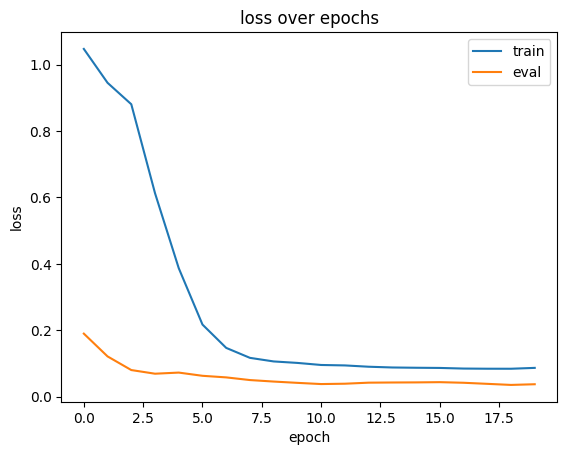

In [43]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

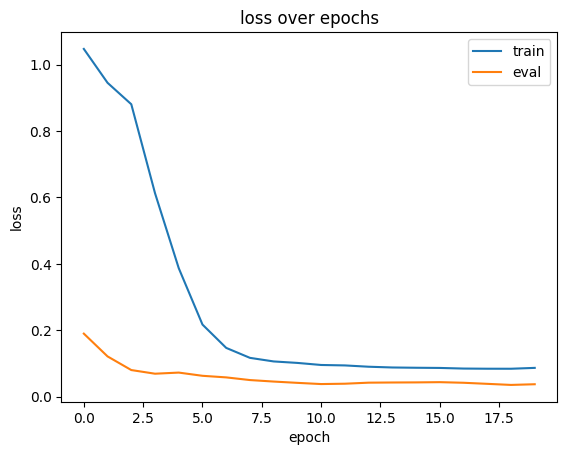

In [44]:
# Plot MSE
plt.plot(train_losses, label = "train")
plt.plot(eval_losses, label = "eval")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss over epochs')
plt.legend()
plt.show()

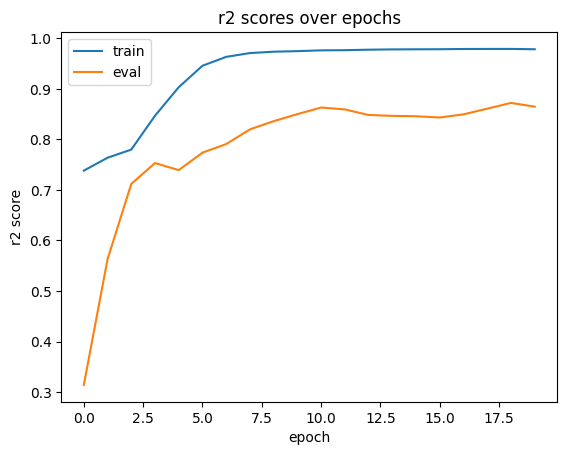

In [45]:
# Plot R2 scores
plt.plot(train_r2_scores, label = "train")
plt.plot(eval_r2_scores, label = "eval")
plt.xlabel('epoch')
plt.ylabel('r2 score')
plt.title('r2 scores over epochs')
plt.legend()
plt.show()